In [2]:
# Import necessary libraries for training, file operations, and plotting
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
from datetime import datetime

# -------------------- BASE DIRECTORY SETUP --------------------
# Define the base folder for runs (should be at the same level as train.ipynb)
BASE_RUNS_DIR = "runs"  # We'll create a new run folder when training starts

# -------------------- HYPERPARAMETERS --------------------
# Define training and model hyperparameters (adjust these easily for tuning)
NUM_EPOCHS = 1        # For now, we run one epoch for testing the pipeline
BATCH_SIZE = 32
LEARNING_RATE = 0.001
RANDOM_STATE = 42

# -------------------- DEVICE CONFIGURATION --------------------
# Check if CUDA (GPU) is available; otherwise, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [3]:
def reduce_memory_usage(df):
    """
    Reduces the memory usage of a DataFrame by downcasting numeric types
    and converting object columns to 'category' dtype if the number of unique values
    is less than 50% of the total entries. This can help speed up computations and lower RAM usage.
    """
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    print(f"Memory usage before optimization: {start_mem:.2f} MB")
    
    # Iterate over each column in the DataFrame
    for col in df.columns:
        col_type = df[col].dtype
        
        # Downcast integers
        if col_type in ['int64', 'int32', 'int16']:
            df[col] = pd.to_numeric(df[col], downcast='integer')
        # Downcast floats
        elif col_type in ['float64', 'float32', 'float16']:
            df[col] = pd.to_numeric(df[col], downcast='float')
        # For object columns, convert to category if it saves space
        elif col_type == 'object':
            num_unique_values = df[col].nunique()
            num_total_values = len(df[col])
            # Convert to category if there are less than 50% unique values (adjust threshold if needed)
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')
    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    print(f"Memory usage after optimization: {end_mem:.2f} MB")
    return df

In [4]:
# -------------------- DATA LOADING --------------------
# Define the path for datasets (train, valid, test are inside ../../datasets/split)
DATA_DIR = "../../datasets"

# Load train, validation, and test datasets using pyarrow engine for Parquet files
train_df = pd.read_parquet(os.path.join(DATA_DIR, "split/train.parquet"), engine="pyarrow")
valid_df = pd.read_parquet(os.path.join(DATA_DIR, "split/valid.parquet"), engine="pyarrow")
test_df  = pd.read_parquet(os.path.join(DATA_DIR, "test.parquet"), engine="pyarrow")

print("Train shape:", train_df.shape)
print("Valid shape:", valid_df.shape)
print("Test shape:", test_df.shape)

# -------------------- MEMORY REDUCTION --------------------
# Apply the memory reduction function to each dataset to optimize performance
train_df = reduce_memory_usage(train_df)
valid_df = reduce_memory_usage(valid_df)
test_df = reduce_memory_usage(test_df)

Train shape: (15399755, 39)
Valid shape: (3849939, 39)
Test shape: (11825698, 38)
Memory usage before optimization: 2135.22 MB
Memory usage after optimization: 2135.22 MB
Memory usage before optimization: 549.10 MB
Memory usage after optimization: 549.10 MB
Memory usage before optimization: 1488.98 MB
Memory usage after optimization: 1488.98 MB


In [5]:
# -------------------- DATA PREPROCESSING --------------------
# Define columns to drop from features (card_id is not used for training; we keep it for submission later if needed)
drop_cols = ['card_id']
target_col = 'target'

# Prepare training features and labels
X_train = train_df.drop(columns=drop_cols + [target_col], errors='ignore')
y_train = train_df[target_col].values

# Prepare validation features and labels
X_valid = valid_df.drop(columns=drop_cols + [target_col], errors='ignore')
y_valid = valid_df[target_col].values

# Convert DataFrames to numpy arrays and ensure they are in float32 format (common for PyTorch)
X_train = X_train.values.astype(np.float32)
X_valid = X_valid.values.astype(np.float32)
y_train = y_train.astype(np.float32).reshape(-1, 1)
y_valid = y_valid.astype(np.float32).reshape(-1, 1)

print("Feature dimensions (train, valid):", X_train.shape, X_valid.shape)

Feature dimensions (train, valid): (15399755, 37) (3849939, 37)


In [6]:
# -------------------- CREATE DATASETS --------------------
# Create TensorDatasets from the numpy arrays for both training and validation data
train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_dataset = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

# -------------------- CREATE DATALOADERS --------------------
# Create DataLoaders to iterate through the datasets in batches
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [20]:
import sys
sys.path.append("models")  # Add models directory to Python path

from fast_torch_models import FastLinearTorch  # Correct if the file is named fast_torch_models.py

# Initialize the model
input_dim = X_train.shape[1]
model = FastLinearTorch(input_dim).to(device)  # This works with your pipeline

In [21]:
from tqdm import tqdm  # progress bar library

# -------------------- CREATE OUTPUT DIRECTORY WHEN TRAINING STARTS --------------------
current_run_dir = os.path.join(BASE_RUNS_DIR, datetime.now().strftime("%Y%m%d_%H%M%S"))
os.makedirs(current_run_dir, exist_ok=True)
OUTPUT_DIR = current_run_dir  # All outputs (model checkpoints, logs, plots, predictions) will be saved here
print("Output directory for this run:", OUTPUT_DIR)

# -------------------- TRAINING SETUP --------------------
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
valid_losses = []
best_valid_loss = float('inf')
checkpoint_path = os.path.join(OUTPUT_DIR, "model_checkpoint.pth")

# -------------------- TRAINING LOOP --------------------
for epoch in range(NUM_EPOCHS):
    print(f"\nStarting Epoch {epoch+1}/{NUM_EPOCHS}")
    model.train()  # Set model to training mode
    running_loss = 0.0

    # Iterate over training batches with a progress bar
    for batch_X, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1} Training", leave=False):
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()         # Clear previous gradients
        outputs = model(batch_X)        # Forward pass
        loss = criterion(outputs, batch_y)  # Compute loss
        loss.backward()                 # Backward pass
        optimizer.step()                # Update weights
        
        running_loss += loss.item() * batch_X.size(0)  # Accumulate weighted loss

    # Calculate average training loss for this epoch
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    print(f"Epoch {epoch+1} Training Loss: {epoch_train_loss:.4f}")
    
    # -------------------- VALIDATION --------------------
    model.eval()  # Set model to evaluation mode
    valid_loss = 0.0
    with torch.no_grad():
        # Use tqdm for validation progress as well
        for batch_X, batch_y in tqdm(valid_loader, desc=f"Epoch {epoch+1} Validation", leave=False):
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            valid_loss += loss.item() * batch_X.size(0)
    
    epoch_valid_loss = valid_loss / len(valid_loader.dataset)
    valid_losses.append(epoch_valid_loss)
    print(f"Epoch {epoch+1} Validation Loss: {epoch_valid_loss:.4f}")
    
    # -------------------- MODEL CHECKPOINTING --------------------
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), checkpoint_path)
        print("Model checkpoint saved at", checkpoint_path)

Output directory for this run: runs/20250318_160530

Starting Epoch 1/1


Epoch 1 Training Loss: 89090746.1199


Epoch 1 Validation Loss: 26247.6665
Model checkpoint saved at runs/20250318_160530/model_checkpoint.pth


Loss logs saved as CSV and TXT.


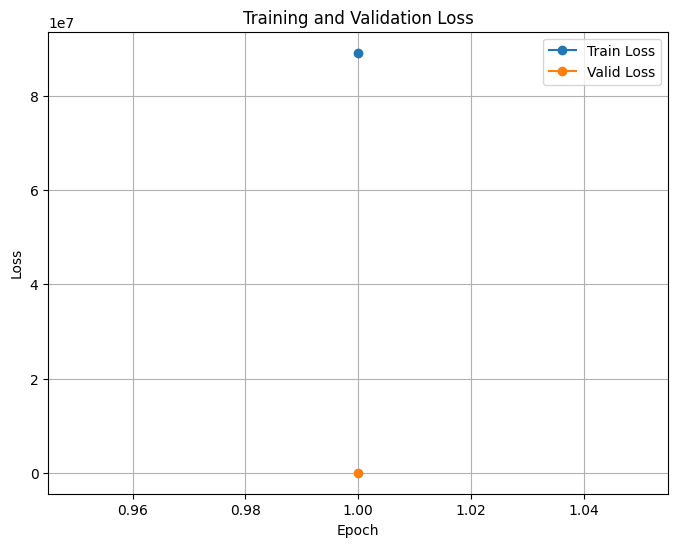

Loss plot saved as an image.


In [22]:
# -------------------- SAVE TRAINING LOGS --------------------
# Create a DataFrame with the loss logs for each epoch
log_df = pd.DataFrame({
    "epoch": list(range(1, NUM_EPOCHS+1)),
    "train_loss": train_losses,
    "valid_loss": valid_losses
})

# Define paths for saving logs (CSV and TXT)
log_csv_path = os.path.join(OUTPUT_DIR, "losses.csv")
log_txt_path = os.path.join(OUTPUT_DIR, "losses.txt")

# Save the log DataFrame to a CSV file
log_df.to_csv(log_csv_path, index=False)
# Also save the log as a plain text file for easy viewing
with open(log_txt_path, "w") as f:
    f.write(log_df.to_string(index=False))

print("Loss logs saved as CSV and TXT.")

# -------------------- GENERATE LOSS PLOTS --------------------
# Plot the training and validation loss curves
plt.figure(figsize=(8,6))
plt.plot(log_df["epoch"], log_df["train_loss"], marker='o', label='Train Loss')
plt.plot(log_df["epoch"], log_df["valid_loss"], marker='o', label='Valid Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

# Save the plot as an image (PNG file)
loss_plot_path = os.path.join(OUTPUT_DIR, "loss_curve.png")
plt.savefig(loss_plot_path)
plt.show()

print("Loss plot saved as an image.")

In [23]:
# -------------------- TEST --------------------
# Load the best model checkpoint (the one with the lowest validation loss)
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

# Preprocess test data: drop card_id if present (as it is an identifier)
X_test = test_df.drop(columns=['card_id'], errors='ignore').values.astype(np.float32)
X_test_tensor = torch.from_numpy(X_test).to(device)

# Generate predictions on the test set
with torch.no_grad():
    predictions = model(X_test_tensor).cpu().numpy()

# Create a submission DataFrame including card_id if available
if 'card_id' in test_df.columns:
    submission = pd.DataFrame({
        "card_id": test_df['card_id'],
        "prediction": predictions.flatten()
    })
else:
    submission = pd.DataFrame({"prediction": predictions.flatten()})

# Define path to save test predictions
submission_path = os.path.join(OUTPUT_DIR, "test_predictions.parquet")

# Save the DataFrame as a Parquet file
df.to_parquet(submission_path, index=False)

print("Test predictions saved.")

Test predictions saved.
